# A/B-тестирование: Анализ гипотез
## Цель
Проект посвящён статистическому анализу данных интернет-магазина, проводящего A/B-тестирование, с целью проверки гипотез, направленных на увеличение выручки. Цель исследования — выявить значимые различия между тестовыми группами, изучить ключевые метрики (средний чек, количество заказов) и принять обоснованное решение о целесообразности внедрения изменений.

## Шаги
В рамках проекта выполнены следующие шаги:

1.   **Загрузка данных**: Данные о гипотезах, заказах и посещениях пользователей загружены из предоставленных источников и преобразованы в формат, удобный для анализа.

2.   **Предобработка данных**: Проведена проверка на наличие пропусков и дубликатов, а также выполнено преобразование данных (например, форматирование дат).

3.   **Приоритизация гипотез**: Использованы фреймворки ICE и RICE для ранжирования гипотез, что позволило определить, какие из них имеют наивысший потенциал для увеличения выручки.

4.   **Анализ A/B-теста**: Построены графики кумулятивной выручки, среднего чека и количества заказов по группам. Проведён анализ относительных изменений ключевых метрик между группами.

5.   **Определение аномалий**: Выявлены и исключены аномальные значения в данных, включая пользователей с высоким количеством заказов и заказы с чрезмерно высокой стоимостью.

6.   **Проверка статистической значимости**: Проведены статистические тесты для проверки различий между группами как на «сырых», так и на «очищенных» данных.

7.   **Принятие решения**: На основе результатов анализа сделан выбор о завершении теста и принятии изменений в группе-победителе.

## Описание данных

**Гипотезы**
*   `Hypothesis` — краткое описание гипотезы
*   `Reach` — охват пользователей по 10-балльной шкале
*   `Impact` — влияние на пользователей по 10-балльной шкале
*   `Confidence` — уверенность в гипотезе по 10-балльной шкале
*   `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы

**Заказы**
*   `transactionId` — идентификатор заказа;
*   `visitorId` — идентификатор пользователя, совершившего заказ;
*   `date` — дата, когда был совершён заказ;
*   `revenue` — выручка заказа;
*   `group` — группа A/B-теста, в которую попал заказ.

**Посещения**
*   `date` — дата;
*   `group` — группа A/B-теста;
*   `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

# Загрузка данных и подготовка их к анализу

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import mannwhitneyu

In [2]:
# Загрузка данных
try:
    # Попытка прочитать файл из Google Drive
    path = '/content/drive/MyDrive/Colab Notebooks/Обучение/Яндекс Практикум/Аналитик данных (расширенный)/Dataset/AB_test/'
    df_hypothesis = pd.read_csv(path + 'hypothesis.csv')
    df_orders = pd.read_csv(path + 'orders.csv')
    df_visitors = pd.read_csv(path + 'visitors.csv')
    print("Файлы успешно загружены из Google Drive")
except FileNotFoundError:
    # Если файлы не найдены, загрузка с сервера Yandex
    try:
        df_hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
        df_orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
        df_visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
        print("Файлы успешно загружены с сервера Yandex")
    except Exception as e:
        # Обработка ошибок при загрузке с сервера Yandex
        print(f"Ошибка при загрузке файлов: {e}")

Файлы успешно загружены из Google Drive


In [3]:
# Функция для обзора данных
def data_review(data):
    display(data.head())
    print('------------------------------------------------------------------------------------------------')
    print(data.info())
    print('------------------------------------------------------------------------------------------------')
    print(data.isnull().sum())
    print('------------------------------------------------------------------------------------------------')
    print(data.duplicated().sum())

In [4]:
# Настройка для вывода полного текста в столбцах
pd.options.display.max_colwidth = 100

## Изучение данных
Изучение данных датафреймов с гипотезами, заказами и посещениями.

In [5]:
# Обзор данных в датафрейме 'hypothesis'
data_review(df_hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
------------------------------------------------------------------------------------------------
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
------------------------------------------------------------------------------------------------
0


### Результаты анализа данных с гипотезами
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: Дубликатов в данных нет.
*   **Типы данных**: Все типы данных корректны.

In [6]:
# Обзор данных в датафрейме 'orders'
data_review(df_orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
------------------------------------------------------------------------------------------------
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
------------------------------------------------------------------------------------------------
0


### Результаты анализа данных с заказами
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: Дубликатов в данных нет.
*   **Типы данных**: Столбец date имеет тип данных 'object' - необходимо преобразовать в формат 'datetime' для корректной работы с датами.

In [7]:
# Обзор данных в датафрейме 'visitors'
data_review(df_visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
------------------------------------------------------------------------------------------------
date        0
group       0
visitors    0
dtype: int64
------------------------------------------------------------------------------------------------
0


### Результаты анализа данных с посещениями
*   **Пропуски**: Пропусков в данных нет.
*   **Дубликаты**: Дубликатов в данных нет.
*   **Типы данных**: Столбец date имеет тип данных 'object' - необходимо преобразовать в формат 'datetime' для корректной работы с датами.

## Предобработка данных

In [8]:
# Преобразование столбцов с датами в формат datetime
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_visitors['date'] = pd.to_datetime(df_visitors['date'])

# Проверка преобразований
print("Типы данных после преобразования в df_orders:")
print(df_orders.dtypes)
print('------------------------------------------------------------------------------------------------')
print("Типы данных после преобразования в df_visitors:")
print(df_visitors.dtypes)

Типы данных после преобразования в df_orders:
transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object
------------------------------------------------------------------------------------------------
Типы данных после преобразования в df_visitors:
date        datetime64[ns]
group               object
visitors             int64
dtype: object


## Заключение

На данном этапе были загружены три датафрейма: `df_hypothesis` (информация о гипотезах), `df_orders` (данные о заказах) и `df_visitors` (данные о посещениях). Все таблицы не содержат пропусков и дубликатов. В таблицах `df_orders` и `df_visitors` был преобразован столбец 'date' в формат 'datetime'.

# Приоритизация гипотез

## Приоритизации гипотез (фреймворк ICE)

Применение фреймворка `ICE` для приоритизации гипотез. Сортировка гипотез по убыванию приоритета.

In [9]:
# Расчет ICE и добавление столбца в dataframe
df_hypothesis['ICE'] = (
    df_hypothesis['Impact'] * df_hypothesis['Confidence'] / df_hypothesis['Efforts']
)

# Округление значений ICE до 2 знаков после запятой
df_hypothesis['ICE'] = df_hypothesis['ICE'].round(2)

# Сортировка гипотез по убыванию ICE
df_hypothesis_ice = df_hypothesis.sort_values(by='ICE', ascending=False)

# Отображение результата
df_hypothesis_ice

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


## Приоритизации гипотез (фреймворк RICE)

Применение фреймворка `RICE` для приоритизации гипотез. Сортировка гипотез по убыванию приоритета.

In [10]:
# Расчет RICE и добавление столбца в dataframe
df_hypothesis['RICE'] = (
    df_hypothesis['Reach'] * df_hypothesis['Impact'] * df_hypothesis['Confidence'] / df_hypothesis['Efforts']
)

# Сортировка гипотез по убыванию RICE
df_hypothesis_rice = df_hypothesis.sort_values(by='RICE', ascending=False)

# Отображение результата
df_hypothesis_rice

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


## Заключение

При применении фреймворка `RICE` приоритеты гипотез изменились: гипотеза о добавлении формы подписки на страницы сайта (Reach=10) вышла на первое место, хотя в `ICE` она занимала третью позицию. Это связано с тем, что в `RICE` учитывается охват пользователей (Reach), которых затронет изменение - фреймворк `RICE` в данном случае более объективен для приоритизации гипотез.

#  Анализ A/B-теста

## Выручка

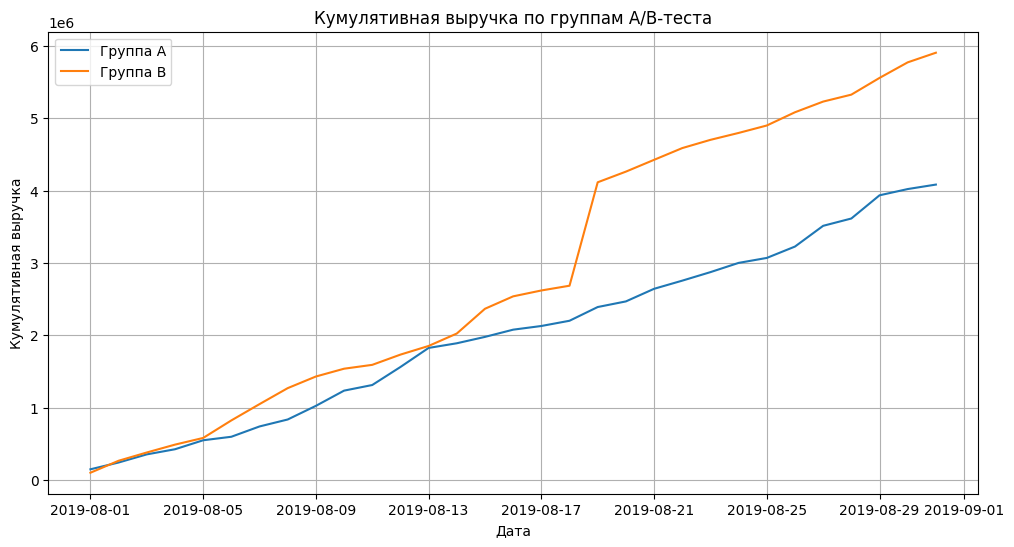

In [11]:
# Подготовка данных для расчета кумулятивных метрик
cumulative_data = df_orders.groupby(['date', 'group']).agg({'revenue': 'sum'}).reset_index()

# Разделение на группы
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

# Построение графика кумулятивной выручки
plt.figure(figsize=(12, 6))
plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue'].cumsum(), label='Группа A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue'].cumsum(), label='Группа B')
plt.title('Кумулятивная выручка по группам A/B-теста')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.grid()
plt.show()

**Выводы**:

*   Кумулятивная выручка группы 'B' стабильно выше выручки группы 'A'.
*   График группы 'B' демонстрирует более резкий рост в период с 18 по 19 августа.

**Предположение**:
*   Возможно, в группе 'B' произошло увеличение количества заказов или среднего чека.

## Средний чек

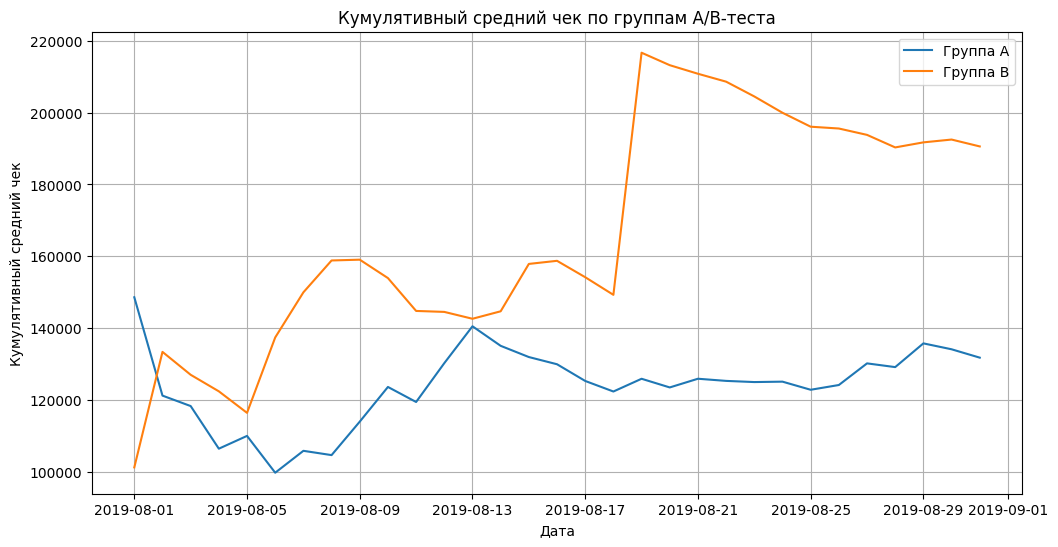

In [12]:
# Расчет кумулятивного среднего чека
cumulative_data['cumulative_avg_check'] = cumulative_data.groupby('group')['revenue'].cumsum() / cumulative_data.groupby('group').cumcount().add(1)

# Разделение на группы для среднего чека
cumulative_avg_check_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_avg_check_B = cumulative_data[cumulative_data['group'] == 'B']

# Построение графика кумулятивного среднего чека
plt.figure(figsize=(12, 6))
plt.plot(cumulative_avg_check_A['date'], cumulative_avg_check_A['cumulative_avg_check'], label='Группа A')
plt.plot(cumulative_avg_check_B['date'], cumulative_avg_check_B['cumulative_avg_check'], label='Группа B')
plt.title('Кумулятивный средний чек по группам A/B-теста')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.grid()
plt.show()

**Выводы:**
*   Кумулятивный средний чек в группе 'B' значительно превышает аналогичный показатель в группе 'A' на протяжении почти всего периода теста.
*   В группе 'B' наблюдается резкий скачок среднего чека примерно в середине теста, после чего он стабилизируется.
*   В группе 'A' средний чек изменяется более плавно, без резких скачков.

**Предположение:**
*   Резкий скачок среднего чека в группе 'B' может быть связан с одним или несколькими крупными заказами, что могло существенно повлиять на показатели группы. Необходимо проверить данные на наличие аномалий.

## Изменение среднего чека по группам

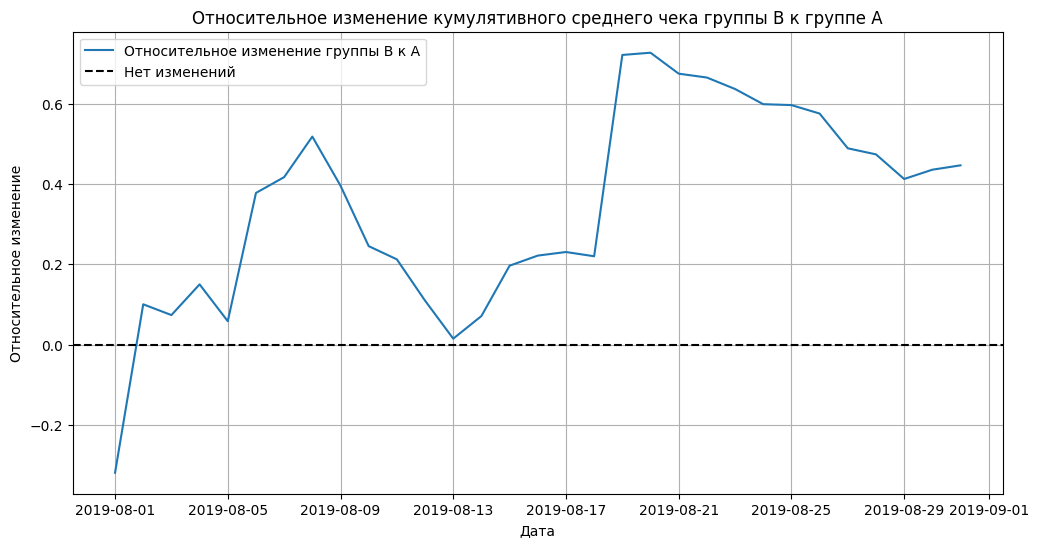

In [13]:
# Подготовка данных для расчета относительных изменений
cumulative_revenue_A = cumulative_avg_check_A['cumulative_avg_check'].reset_index(drop=True)
cumulative_revenue_B = cumulative_avg_check_B['cumulative_avg_check'].reset_index(drop=True)

# Расчет относительных изменений
relative_change = (cumulative_revenue_B / cumulative_revenue_A) - 1

# Построение графика относительного изменения
plt.figure(figsize=(12, 6))
plt.plot(cumulative_avg_check_A['date'].reset_index(drop=True), relative_change, label='Относительное изменение группы B к A')
plt.axhline(y=0, color='black', linestyle='--', label='Нет изменений')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.legend()
plt.grid()
plt.show()

**Выводы:**
*   В начале теста наблюдаются значительные колебания относительного среднего чека группы 'B' относительно группы 'A'.
*   После резкого скачка около середины теста относительное изменение стабилизируется на уровне выше 0.

**Предположение:**
*   Резкий скачок может быть вызван крупным заказом или серией крупных заказов в группе 'B', что значительно повлияло на средний чек.

## Среднее количество заказов

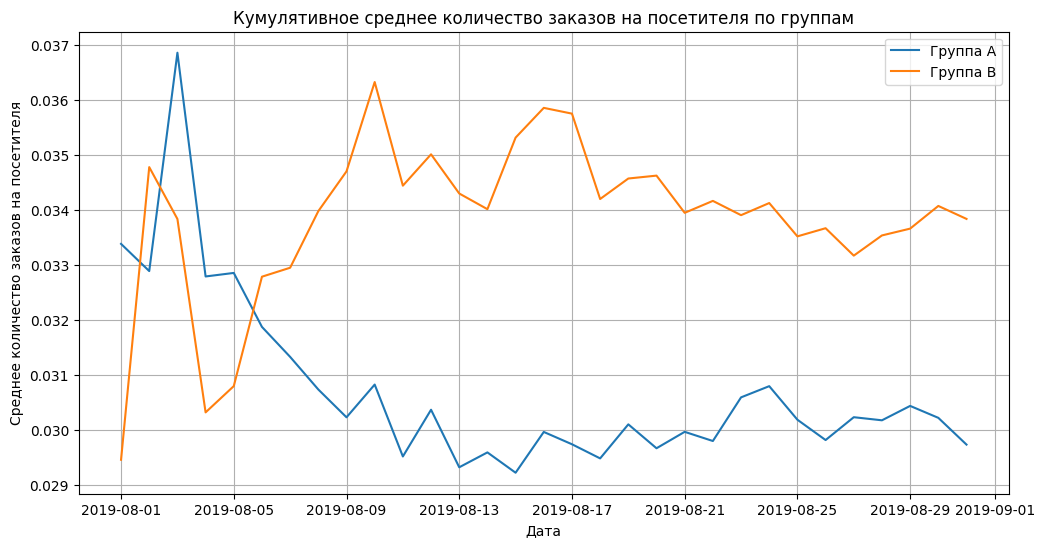

In [14]:
# Объединение данных о заказах и посетителях
cumulative_visitors = df_visitors.groupby(['date', 'group']).agg({'visitors': 'sum'}).reset_index()
cumulative_orders = df_orders.groupby(['date', 'group']).agg({'transactionId': 'count'}).reset_index()

# Слияние данных
cumulative_metrics = cumulative_visitors.merge(cumulative_orders, on=['date', 'group'], how='left').fillna(0)
cumulative_metrics['cumulative_visitors'] = cumulative_metrics.groupby('group')['visitors'].cumsum()
cumulative_metrics['cumulative_orders'] = cumulative_metrics.groupby('group')['transactionId'].cumsum()
cumulative_metrics['cumulative_orders_per_visitor'] = (
    cumulative_metrics['cumulative_orders'] / cumulative_metrics['cumulative_visitors']
)

# Разделение на группы
cumulative_metrics_A = cumulative_metrics[cumulative_metrics['group'] == 'A']
cumulative_metrics_B = cumulative_metrics[cumulative_metrics['group'] == 'B']

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(cumulative_metrics_A['date'], cumulative_metrics_A['cumulative_orders_per_visitor'], label='Группа A')
plt.plot(cumulative_metrics_B['date'], cumulative_metrics_B['cumulative_orders_per_visitor'], label='Группа B')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.legend()
plt.grid()
plt.show()

**Выводы:**
*   Среднее количество заказов на посетителя в группе 'B' выше, чем в группе 'A', начиная с первых дней теста.
*   В группе 'B' наблюдается резкий скачок в первые дни теста, после чего показатель стабилизируется на уровне выше, чем в группе 'A'.
*   В группе 'A' показатель изменяется более равномерно и стабильно на протяжении всего теста.

**Предположение:**
*   Высокий показатель в группе 'B' может быть вызван активностью отдельных пользователей, совершающих большое количество заказов.

## Изменение среднего количества заказов на посетителя

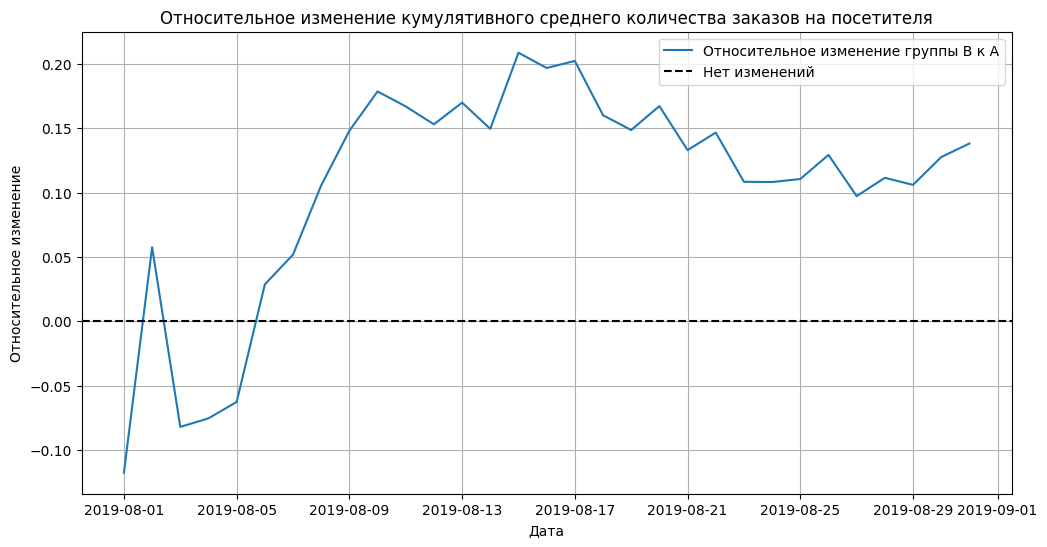

In [15]:
# Расчет относительного изменения среднего количества заказов на посетителя
relative_orders_per_visitor = (
    cumulative_metrics_B['cumulative_orders_per_visitor'].reset_index(drop=True) /
    cumulative_metrics_A['cumulative_orders_per_visitor'].reset_index(drop=True)
) - 1

# Построение графика относительного изменения
plt.figure(figsize=(12, 6))
plt.plot(cumulative_metrics_A['date'].reset_index(drop=True), relative_orders_per_visitor, label='Относительное изменение группы B к A')
plt.axhline(y=0, color='black', linestyle='--', label='Нет изменений')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.legend()
plt.grid()
plt.show()

**Выводы:**
*   Относительное изменение среднего количества заказов на посетителя в группе 'B' по сравнению с группой 'A' на старте теста резко возрастает, достигая пикового значения.
*   В дальнейшем наблюдаются колебания, но показатель стабилизируется на уровне выше 0, что указывает на преимущество группы 'B'.

**Предположение:**
*   Резкий рост в начале теста может быть связан с активностью нескольких пользователей, совершающих большее количество заказов в группе 'B'. После первых дней теста эффект выравнивается, что может свидетельствовать о нормализации пользовательского поведения.

## Точечный график количества заказов по пользователям

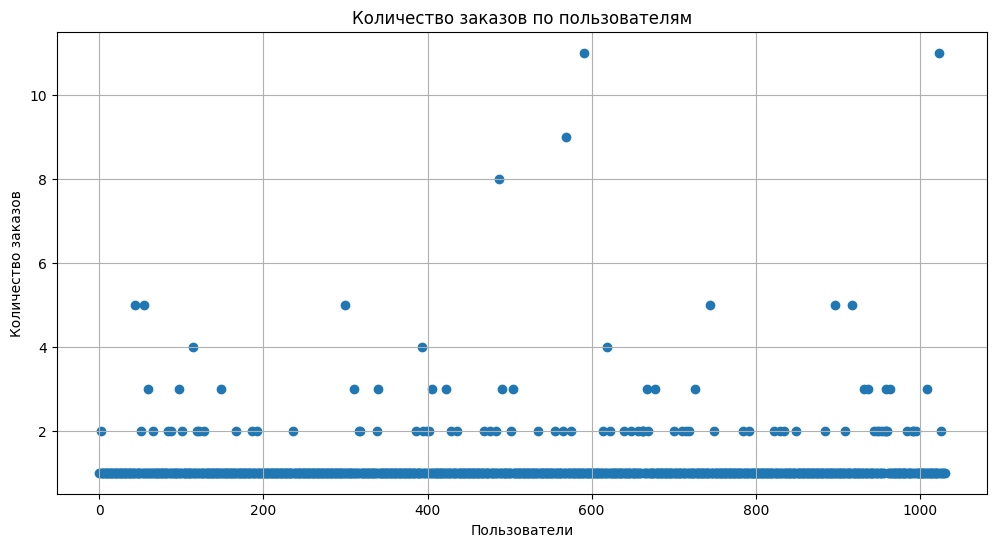

In [16]:
# Подготовка данных для анализа количества заказов по пользователям
orders_by_user = df_orders.groupby('visitorId').agg({'transactionId': 'count'}).reset_index()
orders_by_user.columns = ['visitorId', 'orders']

# Построение точечного графика
plt.figure(figsize=(12, 6))
plt.scatter(range(len(orders_by_user)), orders_by_user['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

**Выводы:**
*   Большинство пользователей совершают всего 1 заказ, реже — 2 заказа.
*   На графике заметны отдельные пользователи, совершающие значительно больше заказов, что можно считать аномалией.

**Предположение:**
*   Высокое количество заказов у отдельных пользователей может существенно влиять на общий результат теста, особенно на средние показатели.

### 95-й и 99-й перцентили количества заказов на пользователя

In [17]:
# Расчет 95-го и 99-го перцентилей с использованием np.percentile
percentile_95 = np.percentile(orders_by_user['orders'], 95)
percentile_99 = np.percentile(orders_by_user['orders'], 99)

percentile_95, percentile_99

(2.0, 4.0)

*   95-й перцентиль: **2**
*   99-й перцентиль: **4**

Граница для определения аномальных пользователей может быть установлена в **3** заказа, чтобы исключить выбросы, превышающие 95-й перцентиль, но не достигшие 99-го.

## Точечный график стоимостей заказов

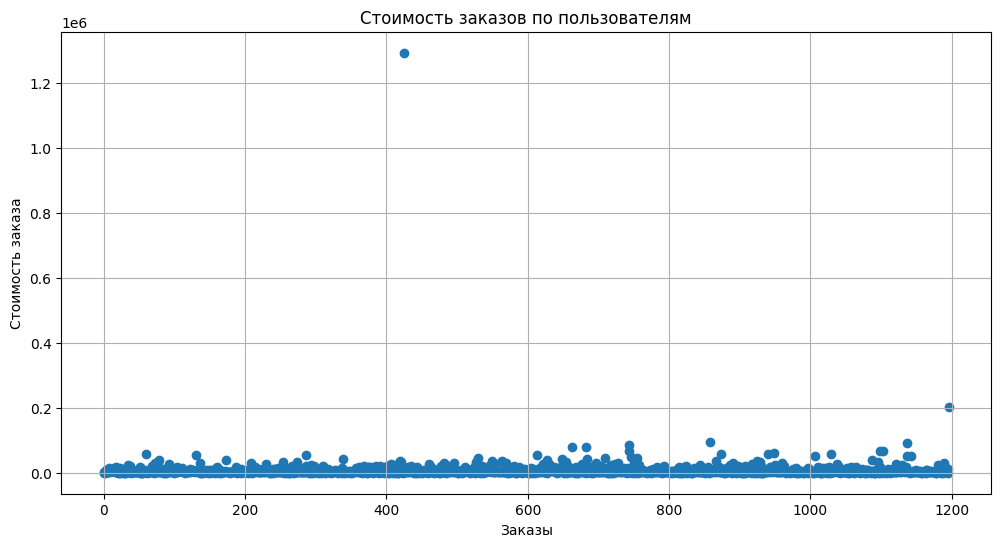

In [18]:
# Подготовка данных для анализа стоимости заказов
order_revenues = df_orders['revenue']

# Построение точечного графика
plt.figure(figsize=(12, 6))
plt.scatter(range(len(order_revenues)), order_revenues)
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.show()

**Выводы:**
*   Основная часть заказов имеет относительно низкую стоимость, но на графике видны отдельные заказы с очень высокой стоимостью, которые резко выделяются.

**Предположение:**
*   Крупные заказы могут сильно искажать средние значения выручки и других метрик.

### 95-й и 99-й перцентили стоимости заказов

In [19]:
# Расчет 95-го и 99-го перцентилей стоимости заказов
percentile_95 = np.percentile(order_revenues, 95)
percentile_99 = np.percentile(order_revenues, 99)

percentile_95, percentile_99

(28000.000000000004, 58233.19999999999)

*   95-й перцентиль: **28,000**
*   99-й перцентиль: **58,233**

Для определения аномальных заказов можно установить границу в 30000 руб — чуть выше 95-го перцентиля, чтобы исключить явные выбросы.

## Cтатистическая значимость различий в среднем количестве заказов по «сырым» данным

**Гипотезы**:
*   Н0: Статистически значимых различий в конверсии между группами нет
*   Н1: Статистически значимые различия в конверсии между группами есть


In [20]:
# Подготовка данных
# Количество заказов по пользователям в каждой группе
orders_per_user_A = df_orders[df_orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': 'count'})
orders_per_user_A.columns = ['visitorId', 'orders']

orders_per_user_B = df_orders[df_orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': 'count'})
orders_per_user_B.columns = ['visitorId', 'orders']

# Добавление пользователей, которые не совершали заказы (0 заказов)
sample_A = pd.concat([orders_per_user_A['orders'], pd.Series(0, index=np.arange(df_visitors[df_visitors['group'] == 'A']['visitors'].sum() - len(orders_per_user_A)))])
sample_B = pd.concat([orders_per_user_B['orders'], pd.Series(0, index=np.arange(df_visitors[df_visitors['group'] == 'B']['visitors'].sum() - len(orders_per_user_B)))])

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(sample_A, sample_B)

stat, p_value

(176473106.0, 0.016792355056752608)

*   U-статистика: **176473106.0**
*   p-значение: **0.017**

**Выводы:**
*   Значение p-уровня ниже 0.05, что позволяет отвергнуть нулевую гипотезу о равенстве средних значений заказов на посетителя между группами. Это свидетельствует о том, что различия между группами являются статистически значимыми.

**Предположение:**
*   Группа 'B' действительно имеет более высокий уровень заказов на посетителя по сравнению с группой 'A' - необходимо подтвердить результат на очищенных данных для исключения влияния выбросов.

## Cтатистическая значимость различий в среднем чеке заказа по «сырым» данным

**Гипотезы**:
*   Н0: Различия в среднем чеке заказа между группами по «сырым» данным статистически не значимы
*   Н1: Различия в среднем чеке заказа между группами по «сырым» данным статистически значимы

In [21]:
# Тест Манна-Уитни для среднего чека заказа
stat_revenue, p_value_revenue = mannwhitneyu(
    df_orders[df_orders['group'] == 'A']['revenue'],
    df_orders[df_orders['group'] == 'B']['revenue']
)

stat_revenue, p_value_revenue

(176175.0, 0.7292909855432458)

*   U-статистика: **176175.0**
*   p-значение: **0.729**

Выводы:
*   Значение p-уровня значительно выше 0.05, что не позволяет отвергнуть нулевую гипотезу о равенстве средних чеков между группами - разницы в среднем чеке между группами 'A' и 'B' по «сырым» данным статистически не значимы.

## Cтатистическая значимость различий в среднем количестве заказов по «очищенным» данным

**Гипотезы**:
*   Н0: Различия в конверсии между группами по «очищенным» данным статистически не значимы
*   Н1: Различия в конверсии между группами по «очищенным» данным статистически значимы

In [22]:
# Определение аномалий
order_limit = 3  # Граница для количества заказов
revenue_limit = 30000  # Граница для стоимости заказов

# Список аномальных пользователей
users_with_many_orders = df_orders.groupby('visitorId').agg({'transactionId': 'count'}).query('transactionId > @order_limit').index
users_with_high_revenue = df_orders.query('revenue > @revenue_limit')['visitorId'].unique()
abnormal_users = np.union1d(users_with_many_orders, users_with_high_revenue)

# Исключение аномальных пользователей из данных
filtered_orders = df_orders[~df_orders['visitorId'].isin(abnormal_users)]

# Подготовка выборок для анализа
orders_per_user_A = filtered_orders[filtered_orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': 'count'})
orders_per_user_A.columns = ['visitorId', 'orders']

orders_per_user_B = filtered_orders[filtered_orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': 'count'})
orders_per_user_B.columns = ['visitorId', 'orders']

sample_A = pd.concat([orders_per_user_A['orders'], pd.Series(0, index=np.arange(df_visitors[df_visitors['group'] == 'A']['visitors'].sum() - len(orders_per_user_A)))])
sample_B = pd.concat([orders_per_user_B['orders'], pd.Series(0, index=np.arange(df_visitors[df_visitors['group'] == 'B']['visitors'].sum() - len(orders_per_user_B)))])

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(sample_A, sample_B)

stat, p_value

(176507267.0, 0.01799563990276024)

*   U-статистика: **176507267.0**
*   p-значение: **0.018**

**Выводы:**
*   Значение p-уровня ниже 0.05, что позволяет отвергнуть нулевую гипотезу о равенстве среднего количества заказов на посетителя между группами.
*   Различия между группами статистически значимы даже после удаления аномальных пользователей.

**Предположение:**
*   Группа 'B' имеет преимущество в среднем количестве заказов на посетителя. Это может указывать на эффективность тестируемого изменения.

## Cтатистическая значимость различий в среднем чеке заказа по «очищенным» данным


**Гипотезы**:
*   Н0: Статистически значимых различий в среднем чеке заказа между группами нет
*   Н1: Статистически значимые различия в среднем чеке заказа между группами есть

In [23]:
# Подготовка данных для анализа среднего чека по очищенным данным
revenue_A = filtered_orders[filtered_orders['group'] == 'A']['revenue']
revenue_B = filtered_orders[filtered_orders['group'] == 'B']['revenue']

# Тест Манна-Уитни
stat_revenue, p_value_revenue = mannwhitneyu(revenue_A, revenue_B)

stat_revenue, p_value_revenue

(140850.0, 0.8154520250421271)

*   U-статистика: **140850.0**
*   p-значение: **0.815**

**Выводы:**
*   Значение p-уровня значительно выше 0.05, что не позволяет отвергнуть нулевую гипотезу о равенстве среднего чека между группами.
*   Различия в среднем чеке между группами 'A' и 'B' по очищенным данным не являются статистически значимыми.

**Предположение:**
*   Средний чек не отличается между группами, что может говорить о том, что тестируемое изменение не влияет на сумму покупок

## Решение

**Остановить тест, зафиксировать победу группы 'B'.**

**Обоснование:**

1.   Среднее количество заказов на посетителя:
  *   Различия между группами 'A' и 'B' статистически значимы как по «сырым», так и по «очищенным» данным.
  *   Группа 'B' показывает преимущество, что указывает на положительный эффект тестируемого изменения.

2.   Средний чек заказа:
  *   Различия в среднем чеке между группами статистически не значимы по «сырым» и «очищенным» данным.
  *   Это говорит о том, что тестируемое изменение не влияет на сумму покупок, но не отменяет значимости прироста количества заказов.

3.   Цели теста:
  *   Основной метрикой для оценки изменений является количество заказов. Успешное увеличение этого показателя в группе 'B' является достаточным основанием для принятия решения.

**Таким образом, тест можно завершить, зафиксировав победу группы 'B'.**